In [102]:
%load_ext autoreload
%autoreload 2

import parse_hipnogram as ph
from parse_signal import load_psg, load_neuroon


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal as sig
import seaborn as sns
import h5py
import scipy.signal as sig

%matplotlib notebook
stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgray' }


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# prep_for_spectral rearrenges the rows to have start timestamp and end timestamp in the same row 
# (otherwise it is in consecutive rows)
neuroon_hipnogram = ph.prep_for_spectral(ph.parse_neuroon_stages(time_shift = -160))
psg_hipnogram = ph.prep_for_spectral(ph.parse_psg_stages())


parse_hipnogram.py:68: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  neuroon_stages = neuroon_stages.sort(columns = 'timestamp')
/Users/ryszardcetnarski/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ryszardcetnarski/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
parse_hipnogram.py:135: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=....

In [16]:
psg_signal =  load_psg('F3-A2')
neuroon_signal =  load_neuroon()

In [17]:
def make_stage_slices(sampling_rate, hipno, signal):

    
    slices = {}
    spectra = {}
    frequency = {}
    for name, sleep_stage in hipno.groupby('stage_name'):
        stage_spectra = []
        stage_slices = []
        stage_freqs = []

        for idx, phase_event in sleep_stage.iterrows():
            _slice = np.array(signal.loc[phase_event['starts'] : phase_event['ends']])
            if(_slice.size !=  0):
                stage_slices.append(_slice)
                   
                freqs, pxx = sig.welch(_slice, sampling_rate, nperseg=1024, noverlap = 256) 
                stage_spectra.append(pxx)
                stage_freqs.append(freqs)
            
        slices[name] = stage_slices
        spectra[name] = np.array(stage_spectra)
        frequency[name] = np.array(stage_freqs)
        
    return slices, spectra, frequency
    
    

In [18]:
slices, spectra, frequency = make_stage_slices(125, neuroon_hipnogram, neuroon_signal)

In [103]:
def plot_spectra_by_stage(spectra, frequency,psg_or_noo):

    fig, axes = plt.subplots()
    fig.suptitle('neuroon', fontweight = ('bold'))
    axes.set_xlabel('Frequency (Hz)')
    fig.text(0.04, 0.5, 'power spectral density', va='center', rotation='vertical')    
    
    for stage_name, spectrum in spectra.items():
        if(stage_name != 'wake'):
            # limit the plot to 0hz - 50hz range
            max_idx = np.argmax(frequency[stage_name][0]  > 50)
            print(max_idx)
            #sns.tsplot(data=np.log(spectrum[:, 0: max_idx]), time = frequency[0, 0 : max_idx], condition = stage_name , legend = True, color=color_dict , ax = axes)        
        #    for pxx, f in zip(spectrum, frequency):
              #  axes.plot(f, np.log(pxx), color = color_dict[stage_name], alpha = 0.1)
            grand_avg = np.log(spectrum).mean(axis = 0)
            std =np.log(spectrum).std(axis = 0)
            # Select only part of frequencies
            grand_avg = grand_avg[0:max_idx]
#            print(len(grand_avg))

            std = std[0:max_idx]
            #frequency = frequency[stage_name][0]
#           
            lim_freq = frequency[stage_name][0][0:max_idx]
            #print(len(frequency))


            axes.plot(lim_freq, grand_avg ,color = stage_color_dict[stage_name], label = stage_name)
            
            axes.fill_between(lim_freq, grand_avg - std, grand_avg + std, color = stage_color_dict[stage_name], alpha = 0.2)

    plt.legend()

In [104]:
np.argmax(frequency['N2'][0] >50)


410

<IPython.core.display.Javascript object>


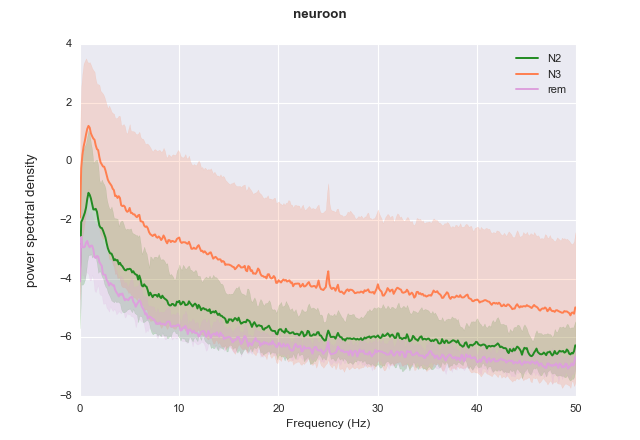

410
410
410


In [105]:
plot_spectra_by_stage(spectra, frequency,'neuroon')

In [6]:

from IPython.display import IFrame
IFrame("images/F3-A2_by_phase.pdf", width=700, height=600)

In [7]:
IFrame("images/neuroon_by_phase.pdf", width=700, height=600)